<a href="https://colab.research.google.com/github/PiHau/2024_MLEES/blob/main/Notebooks/Week_9_Generative_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Exercise) Autoencoders, Generative Adversarial Networks, and Diffusion Models

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Th%C3%A9%C3%A2tre_D%E2%80%99op%C3%A9ra_Spatial.png/920px-Th%C3%A9%C3%A2tre_D%E2%80%99op%C3%A9ra_Spatial.png)

Théâtre D'opéra Spatial, 2022 artwork created by Jason M. Allen with Midjourney

The code in this notebook is inspired by the work of Aurélien Géron, particularly his book (Hands-on ML) and accompanying exercise notebooks. Additionally, valuable insights and techniques have been drawn from the comprehensive tutorials and resources provided by https://machinelearningmastery.com.

**Autoencoders**, **GANs**, and **Diffusion Models** are all machine learning algorithms that can generate new data, often in an unsupervised manner. **Autoencoders** learn to compress and decompress data, capturing underlying patterns. **GAN**s (Generative adversarial networks) use two competing neural networks: a generator that creates new data and a discriminator that evaluates its authenticity. **Diffusion Models** gradually add noise to data and then learn to remove it, producing realistic samples. These models have applications in image generation, style transfer, and more.

We'll be implementing them on the [CIFAR-10](https://www.cs.toronto.edu/%7Ekriz/cifar.html) dataset to explore their capabilities in **capturing patterns, image generation and style transfer**. These models offer powerful techniques for learning latent representations, generating new data, and understanding complex patterns within data.


*Note* : CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

**Learning Objectives:**

1. Implement VAEs, GANs, and Diffusion Models in TensorFlow.
2. Understand the key differences and trade-offs between these models.
3. Experiment with hyperparameters to improve model performance.

<font color='red'>Running all parts of this notebook can be time-consuming. Feel free to reduce the number of epochs or interrupt the training process if it takes too long.</font>

## Imports and Data Loading

In [175]:
%%capture
!pip install tensorflow-gpu==2.8.0

# You may need to restart the runtime to use the
# specific `tf` version installed for this notebook

In [176]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
from packaging import version
from sklearn.manifold import TSNE

# make notebook reproducible
tf.random.set_seed(42)

# make plot prettier
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [177]:
# for easy plotting later on
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

<font color='red'>You may need to restart the runtime the first time you run it to use the specific `tf` version installed for this notebook</font>

### **Q1) Load the dataset, scale it, and split it into a training set, a validation set, and a test set**

In [178]:
#@markdown Fill in the blank code. Double-click here to reveal
# Load the CIFAR-10 dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values to the range [0, 1]
# RGB values are between 0 and 256
X_train_full = X_train_full / 256
X_test = X_test / 256

# Split the training set into a training set and a validation set
# Get 5000 images as the validation set
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [179]:
#@markdown Fill in the blank code. Double-click here to reveal
# Load the CIFAR-10 dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values to the range [0, 1]
# RGB values are between 0 and 256
X_train_full = X_train_full / 256
X_test = X_test / 256

# Split the training set into a training set and a validation set
# Get 5000 images as the validation set
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [180]:
### Get familiar with CIFAR-10 dataset
# Get the shape of the images
X_train.shape

(45000, 32, 32, 3)

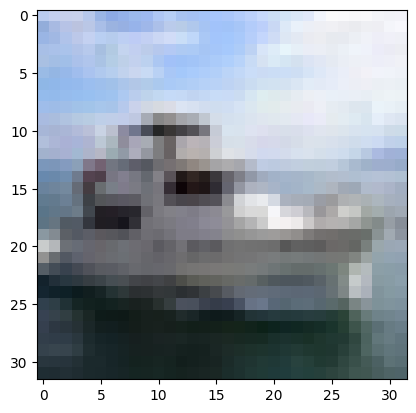

In [208]:
# Index aléatoire dans X_train
random_index = np.random.randint(0, len(X_train))
plt.imshow(X_train[random_index])
plt.show()

## 亖 Stacked Autoencoders

Autoencoders, like other neural networks, can employ multiple hidden layers, often referred to as **stacked autoencoders** or **deep autoencoders**. This layered architecture enables autoencoders to learn progressively more complex representations of the input data.

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).



Each epoch with this recommended parameters will take ~ 1 min 10 sec;


### **Q2) Complete the stacked autoencoder architecture below**

In [182]:
# Define the stacked encoder architecture
# Recommended 512, 256 units for the Dense layers and ReLU activation
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
])

In [183]:
# Define the stacked decoder architecture
# Recommended 512 and pixel count in one image as units for the Dense layers
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(32 * 32 * 3),
    tf.keras.layers.Reshape([32, 32, 3])
])

In [184]:
# Combine encoder and decoder into the stacked autoencoder
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

# Compile the stacked autoencoder
# Recommended loss is MSE and recommended optimizer is NAdam
stacked_ae.compile(loss="mse", optimizer="nadam")


history = stacked_ae.fit(X_train, X_train, epochs=8,validation_data=(X_valid, X_valid))

Epoch 1/8
1407/1407 [==============================] - 119s 83ms/step - loss: 0.0267 - val_loss: 0.0197
Epoch 2/8
1407/1407 [==============================] - 96s 68ms/step - loss: 0.0176 - val_loss: 0.0170
Epoch 3/8
1407/1407 [==============================] - 92s 65ms/step - loss: 0.0154 - val_loss: 0.0137
Epoch 4/8
1407/1407 [==============================] - 93s 66ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 5/8
1407/1407 [==============================] - 92s 65ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 6/8
1407/1407 [==============================] - 93s 66ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 7/8
1407/1407 [==============================] - 95s 67ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 8/8
1407/1407 [==============================] - 90s 64ms/step - loss: 0.0114 - val_loss: 0.0109


This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:



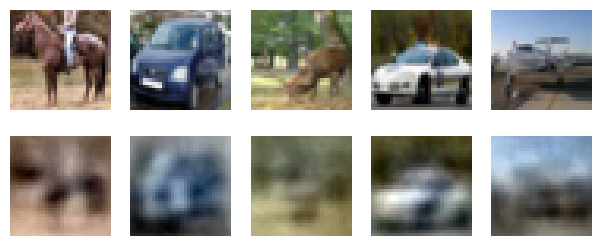

In [185]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index]) #, cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index]) #, cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
plt.show()

<font color='red'>The reconstructions look fuzzy, but remember that the images were compressed down to just 256 (or whatever number of neurons in your last layer you choosed) numbers, instead of 3072.</font>

### **Q3) Visualize the CIFAR-10 dataset using [tsne](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)**

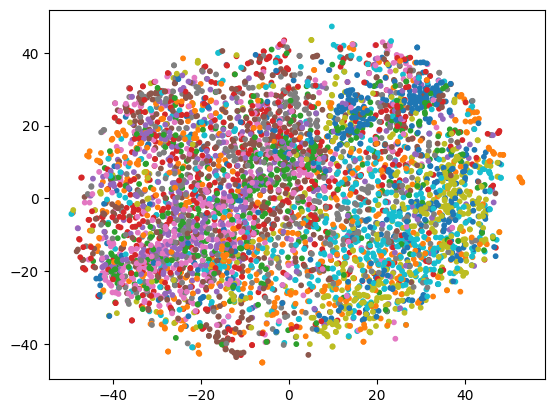

In [186]:
#@markdown Fill in the blank code. Double-click here to reveal
# Predict the validation set
X_valid_compressed = stacked_encoder.predict(X_valid)

# Apply t-SNE for dimensionality reduction
# You can initializes with PCA, and the learning_rate to auto
tsne = TSNE(init='pca', learning_rate='auto', random_state=42)

# Transform the compressed validation set into 2D
X_valid_2D = tsne.fit_transform(X_valid_compressed)

# Plot the 2D data
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram prettier:

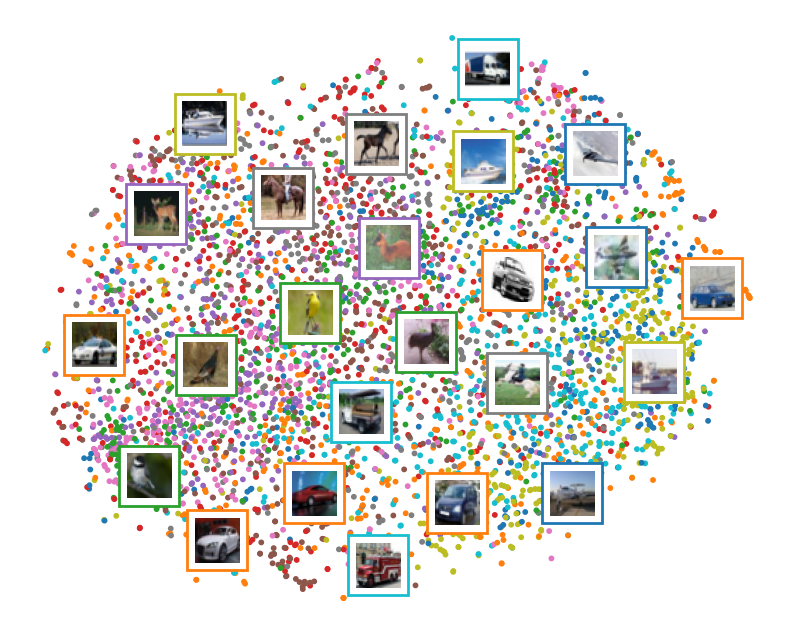

In [187]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

## 🅶 GANs


Generative Adversarial Networks (**GAN**s) represent one of the most fascinating concepts in computer science today. They involve training two models in tandem through an adversarial process. The generator, often called "the artist," learns to produce images that appear realistic, while the discriminator, known as "the art critic," learns to distinguish between genuine images and those created by the generator.

During training, the generator gets better at making realistic images, while the discriminator gets better at spotting fakes. They reach a balance when the discriminator can't tell real images from fake ones anymore.

### **Q8) Complete the GAN architecture below**

In [188]:
# Define the size of the latent space
codings_size = 20

In [189]:
from keras.layers import Dense, Reshape, Flatten
from keras.models import Sequential
generator = Sequential([
    Dense(units=300, activation="relu", kernel_initializer="he_normal"),
    Dense(units=450, activation="relu", kernel_initializer="he_normal"),
    Dense(units=32 * 32 * 3, activation="sigmoid"),
    Reshape(target_shape=[32, 32, 3])
])

In [190]:
# Build the discriminator model
discriminator = Sequential([
    Flatten(),  # Aplatissement de l'image d'entrée
    Dense(units=450, activation="relu", kernel_initializer="he_normal"),  # Couche cachée avec 450 neurones
    Dense(units=300, activation="relu", kernel_initializer="he_normal"),  # Couche cachée avec 300 neurones
    Dense(units=1, activation="sigmoid")  # Couche de sortie pour classification binaire
])

In [191]:
# Combine generator and discriminator into a GAN
# The GAN model consists of the generator followed by the discriminator
gan = tf.keras.Sequential([generator, discriminator])

In [192]:
#@markdown Fill in the blank code. Double-click here to reveal
# Define the size of the latent space, e.g. 30
codings_size = 30

# Build the generator model
Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(300, activation="relu", kernel_initializer="he_normal"),  # Expand to 300 units
    Dense(450, activation="relu", kernel_initializer="he_normal"),  # Expand to 450 units
    Dense(32 * 32 * 3, activation="sigmoid"),  # Output layer to match 32x32x3 image
    tf.keras.layers.Reshape([32, 32, 3])  # Reshape to 32x32x3 CIFAR image
])

# Build the discriminator model
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  # Flatten the input image
    Dense(450, activation="relu", kernel_initializer="he_normal"),  # Hidden layer with 450 units
    Dense(300, activation="relu", kernel_initializer="he_normal"),  # Hidden layer with 300 units
    Dense(1, activation="sigmoid")  # Output layer for binary classification
])

# Combine generator and discriminator into a GAN
# The GAN model consists of the generator followed by the discriminator
gan = tf.keras.Sequential([generator, discriminator])

In [193]:
# Compile the discriminator model
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')


In [194]:
# Set discriminator to non-trainable when training the GAN to freeze its weights
discriminator.trainable = False


In [195]:
# Compile the GAN model
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [196]:
# Define batch size for training
batch_size = 32

# Create a TensorFlow dataset from the training data
# Shuffle the data with a buffer size of 1000 for randomness
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)

# Batch the data into chunks of size batch_size
# Prefetch data to improve performance by overlapping data preprocessing and model training
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

### **Q9) Train the GAN to generate new images**

In [197]:
# Helper function to train the GAN
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")

        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_batch = tf.cast(X_batch, tf.float32)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

Epoch 1/5


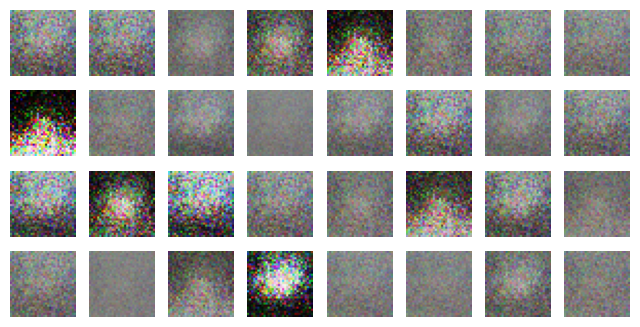

Epoch 2/5


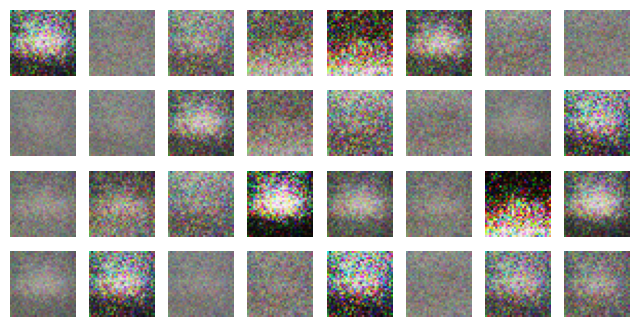

Epoch 3/5


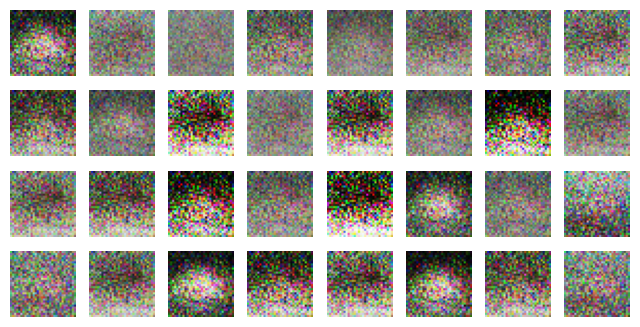

Epoch 4/5


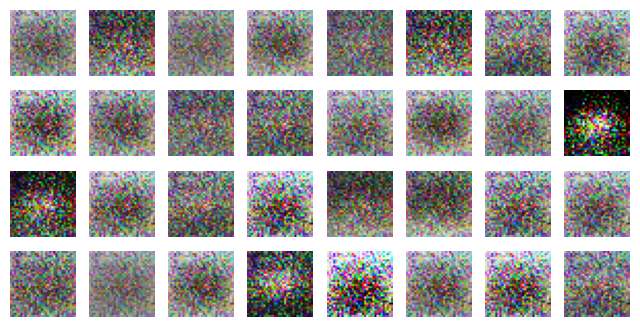

Epoch 5/5


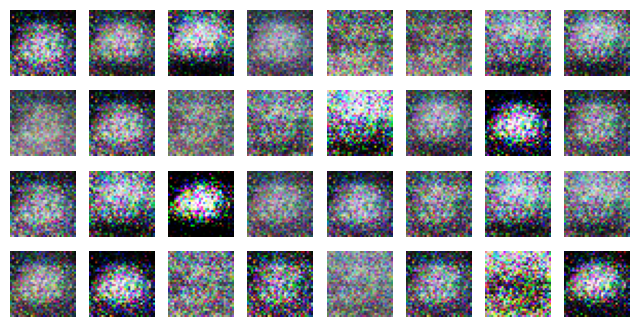

In [173]:
# Train the GAN model, with e.g. 50 epochs
train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

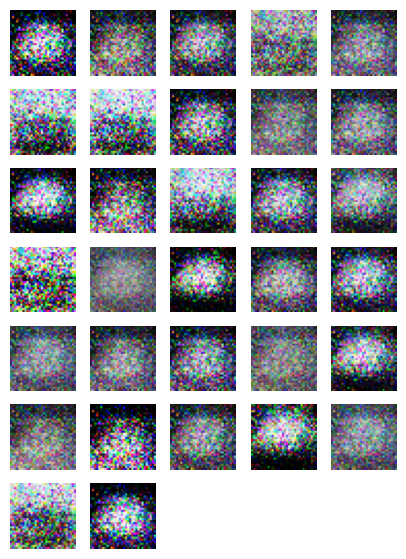

In [174]:
# Generate a batch of latent vectors
codings = tf.random.normal(shape=[batch_size, codings_size])

# Generate images using the trained generator (using the `codings`)
generated_images = generator.predict(codings)

# Plot the generated images, e.g. 5
plot_multiple_images(generated_images, 5)
plt.show()


Deep GANs (Generative Adversarial Networks) are a type of GAN that use deep neural networks in both the generator and the discriminator. By leveraging deep architectures, these models can create more complex and realistic images or data.

## య Diffusion models

Starting with an image from the dataset, at each time step $t$, the diffusion process adds Gaussian noise with mean 0 and variance $\beta_t$. The model is then trained to reverse that process. More specifically, given a noisy image produced by the forward process, and given the time $t$, the model is trained to predict the total noise that was added to the original image, scaled to variance 1.

The [DDPM paper](https://arxiv.org/abs/2006.11239) increased $\beta_t$ from $\beta_1$ = 0.0001 to $\beta_T = $0.02 ($T$ is the max step), but the [Improved DDPM paper](https://arxiv.org/pdf/2102.09672.pdf) suggested using the following $\cos^2(\ldots)$ schedule instead, which gradually decreases $\bar{\alpha_t} = \prod_{i=0}^{t} \alpha_i$ from 1 to 0, where $\alpha_t = 1 - \beta_t$:

In [198]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # extra code – for reproducibility
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

In the DDPM paper, the authors used $T = 1,000$, while in the Improved DDPM, they bumped this up to $T = 4,000$, so we use this value. The variable `alpha` is a vector containing $\alpha_0, \alpha_1, ..., \alpha_T$. The variable `alpha_cumprod` is a vector containing $\bar{\alpha_0}, \bar{\alpha_1}, ..., \bar{\alpha_T}$.

Let's plot `alpha_cumprod`:

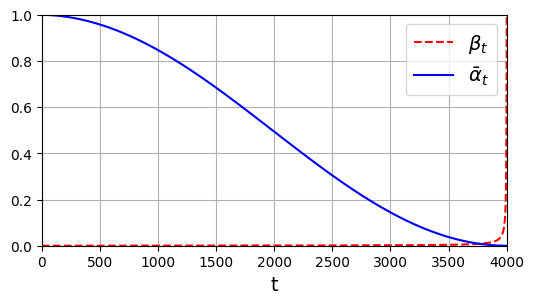

In [199]:
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
plt.show()

The `prepare_batch()` function takes a batch of images and adds noise to each of them, using a different random time between 1 and $T$ for each image, and it returns a tuple containing the inputs and the targets:

* The inputs are a `dict` containing the noisy images and the corresponding times. The function uses equation (4) from the DDPM paper to compute the noisy images in one shot, directly from the original images. It's a shortcut for the forward diffusion process.
* The target is the noise that was used to produce the noisy images.

In [200]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

### **Q12) Prepare one `tf.data.Dataset` for training, and one for validation.**

In [201]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    # Create a dataset from input data
    ds = tf.data.Dataset.from_tensor_slices(X)

    # Optionally shuffle the dataset
    if shuffle:
        ds = ds.shuffle(10000)  # e.g. 10000 for buffer size

    # Batch the data, apply necessary preparation and prefetch one at a time
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

# Prepare the training and validation datasets
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

As a quick sanity check, let's take a look at a few training samples, along with the corresponding noise to predict, and the original images (which we get by subtracting the appropriately scaled noise from the appropriately scaled noisy image):

In [202]:
def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

Original images


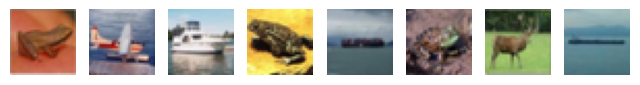

Time steps: [2644 3772 3918 1208 3304 2526 2095 2652]
Noisy images


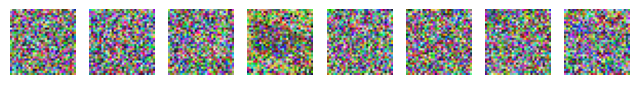

Noise to predict


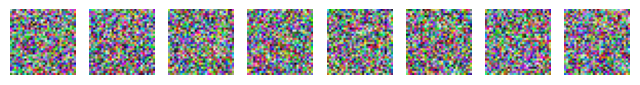

In [203]:
# Plot original images, noisy images and the noise to predict
print("Original images")
plot_multiple_images(((X_original[:8].numpy()+1)*128).astype(np.uint8))
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(((X_dict["X_noisy"][:8].numpy()+1)*128).astype(np.uint8))
plt.show()
print("Noise to predict")
plot_multiple_images(((Y_noise[:8].numpy()+1)*128).astype(np.uint8))
plt.show()

### **Q13) Complete the diffusion model architecture below**

Now we're ready to build the diffusion model itself. It will need to process both images and times. We will encode the times using a sinusoidal encoding, as suggested in the DDPM paper, just like in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper. Given a vector of _m_ integers representing time indices (integers), the layer returns an _m_ × _d_ matrix, where _d_ is the chosen embedding size.

In [204]:
embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

In [205]:
# The size of the embedding, e.g., 64
embed_size = 64

# Custom layer to encode time steps with sinusoidal embeddings
class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        # Initialize layer and ensure embed_size is even
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"

        # Create a meshgrid for time steps and embedding indices
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))

        # Initialize the time embeddings matrix
        t_emb = np.empty((T + 1, embed_size))

        # Fill even indices with sine values and odd indices with cosine values
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T

        # Convert the embeddings to TensorFlow constant
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    # Method to fetch time encodings for `input` time steps
    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

Now let's build the model. In the Improved DDPM paper, they use a UNet model. We'll create a UNet-like model, that processes the image through `Conv2D` + `BatchNormalization` layers and skip connections, gradually downsampling the image (using `MaxPooling` layers with `strides=2`), then growing it back again (using `Upsampling2D` layers). Skip connections are also added across the downsampling part and the upsampling part. We also add the time encodings to the output of each block, after passing them through a `Dense` layer to resize them to the right dimension.

* **Note**: an image's time encoding is added to every pixel in the image, along the last axis (channels). So the number of units in the `Conv2D` layer must correspond to the embedding size, and we must reshape the `time_enc` tensor to add the width and height dimensions.
* This UNet implementation was inspired by keras.io's [image segmentation example](https://keras.io/examples/vision/oxford_pets_image_segmentation/), as well as from the [official diffusion models implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py). Compared to the first implementation, I added a few things, especially time encodings and skip connections across down/up parts. Compared to the second implementation, I removed a few things, especially the attention layers. It seemed like overkill for Fashion MNIST, but feel free to add them.

In [209]:
def build_diffusion_model():
    # Define inputs: noisy image and time step
    X_noisy = tf.keras.layers.Input(shape=[32, 32, 3], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")

    # Encode the time step using the custom TimeEncoding layer that takes `T` and `embed_size`
    T = 1000  # e.g., the total number of diffusion steps
    embed_size = 64  # example embedding size for time encoding
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16  # initial dimension for convolution
    # Initial convolution with zero padding for the noisy input
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    # Adapt the time encoding and add it to the image feature map
    time = tf.keras.layers.Dense(dim)(time_enc)
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time info to every pixel

    # Keep track of skip connections and initiate a residual connection
    skip = Z
    cross_skips = []  # for skip connections in UNet structure

    # Downsampling block
    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        # Store intermediate output for skip connection
        cross_skips.append(Z)

        # Downsample and add residual connection
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2, padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        # Add time information to downsampled feature maps
        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    # Upsampling block
    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        # Upsample and add residual connection
        Z = tf.keras.layers.UpSampling2D(2)(Z)
        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        # Add time encoding and merge with corresponding downsample skip connection
        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    # Final convolution layer, output cropped to remove padding
    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]

    # Return the model with inputs and outputs
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])



Let's train the model!

In [211]:
# Build and compile the diffusion model
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")

# Create a checkpoint callback to save the best model during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

# Train the model with the training and validation datasets with e.g. 100 epochs
history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[checkpoint_cb])

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 10, 10, 64), (None, 9, 9, 128)]

Now that the model is trained, we can use it to generate new images. For this, we just generate Gaussian noise, and pretend this is the result of the diffusion process, and we're at time $T$. Then we use the model to predict the image at time $T - 1$, then we call it again to get $T - 2$, and so on, removing a bit of noise at each step. At the end, we get an image that looks like it's from the Fashion MNIST dataset. The equation for this reverse process is at the top of page 4 in the DDPM paper (step 4 in algorithm 2).

In [212]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

In [213]:
# Generate images
X_gen = generate(model)

# Plot the generated images
plot_multiple_images(X_gen.numpy(), 5)
plt.show()

NameError: name 'model' is not defined

Some of these images are really convincing! Compared to GANs, diffusion models tend to generate more diverse images, and they have surpassed GANs in image quality. Moreover, training is much more stable. However, generating images takes *much* longer.